In [15]:
import random
import math
import csv
import matplotlib.pyplot as plt
from copy import deepcopy


In [11]:
def plotRoutes(routes, depot, title='VRPTW Routes'):
    plt.figure(figsize=(8, 8))
    for idx, route in enumerate(routes):
        x = [cust['x'] for cust in route]
        y = [cust['y'] for cust in route]
        plt.plot(x, y, marker='o', label=f'Route {idx+1}')
    plt.scatter(depot['x'], depot['y'], color='red', zorder=10, label='Depot')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.legend()
    plt.show()


In [16]:
file = 'data/c1type_vc200/C101.csv'
data = []
with open(file, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        data.append(row)

CUSTOMERS = []
for customer in data[1:]:
    customer = {
        'id': int(customer[0]) - 1,
        'x': float(customer[1]),
        'y': float(customer[2]),
        'demand': float(customer[3]),
        'ready_time': float(customer[4]),
        'due_time': float(customer[5]),
        'service_time': float(customer[6])
    }
    CUSTOMERS.append(customer)
DEPOT = {
    'id': int(data[0][0]) - 1,
    'x': float(data[0][1]),
    'y': float(data[0][2]),
    'demand': float(data[0][3]),
    'ready_time': float(data[0][4]),
    'due_time': float(data[0][5]),
    'service_time': float(data[0][6])
}


VCAPACITY = 200


In [6]:
def calculate_distance(a, b):
    return ((a["x"] - b["x"])**2 + (a["y"] - b["y"])**2)**0.5

In [7]:
def generate_initial_solution(customers):
    unvisited = deepcopy(customers)
    routes = []

    while len(unvisited) > 0:
        route = []
        route.append(DEPOT)
        possible_to_visit = unvisited.copy()
        
        while len(possible_to_visit) > 0:
            # 1. find nearest customer
            # nearest_customers = sorted(possible_to_visit, key=lambda x: vehicle.route[-1].calculateDst(x))[:5]
            random_number = random.uniform(0, 1)
            if random_number < 0.3:
                nearest_customer = min(possible_to_visit, key=lambda x: x.servicetime)
            else:
                nearest_customer = min(possible_to_visit, key=lambda x: vehicle.route[-1].calculateDst(x))

            possible_to_visit.remove(nearest_customer)
            # 2. check if can fit
            if not vehicle.canFit(nearest_customer):
                continue
            # 3. can make back to depot
            if not vehicle.canMakeBackToDepotFromCustomer(nearest_customer):
                continue
            # 4. can make it before due date
            if not vehicle.canVisitBeforeDueDate(nearest_customer):
                continue
            # 5. can visit in ready time or make it wait
            # 6. visit customer
            #? could take few customers in range and check min(readytime) and visit that customer
            if vehicle.canVisitInReadyTime(nearest_customer):
                vehicle.visit(nearest_customer)
            else:
                vehicle.waitForCustomer(nearest_customer)
                vehicle.visit(nearest_customer)
            # 7. remove customer from unvisited
            unvisited.remove(nearest_customer)
        
        vehicle.route.append(depot)
        vehicles.append(vehicle)
    
    return vehicles

97


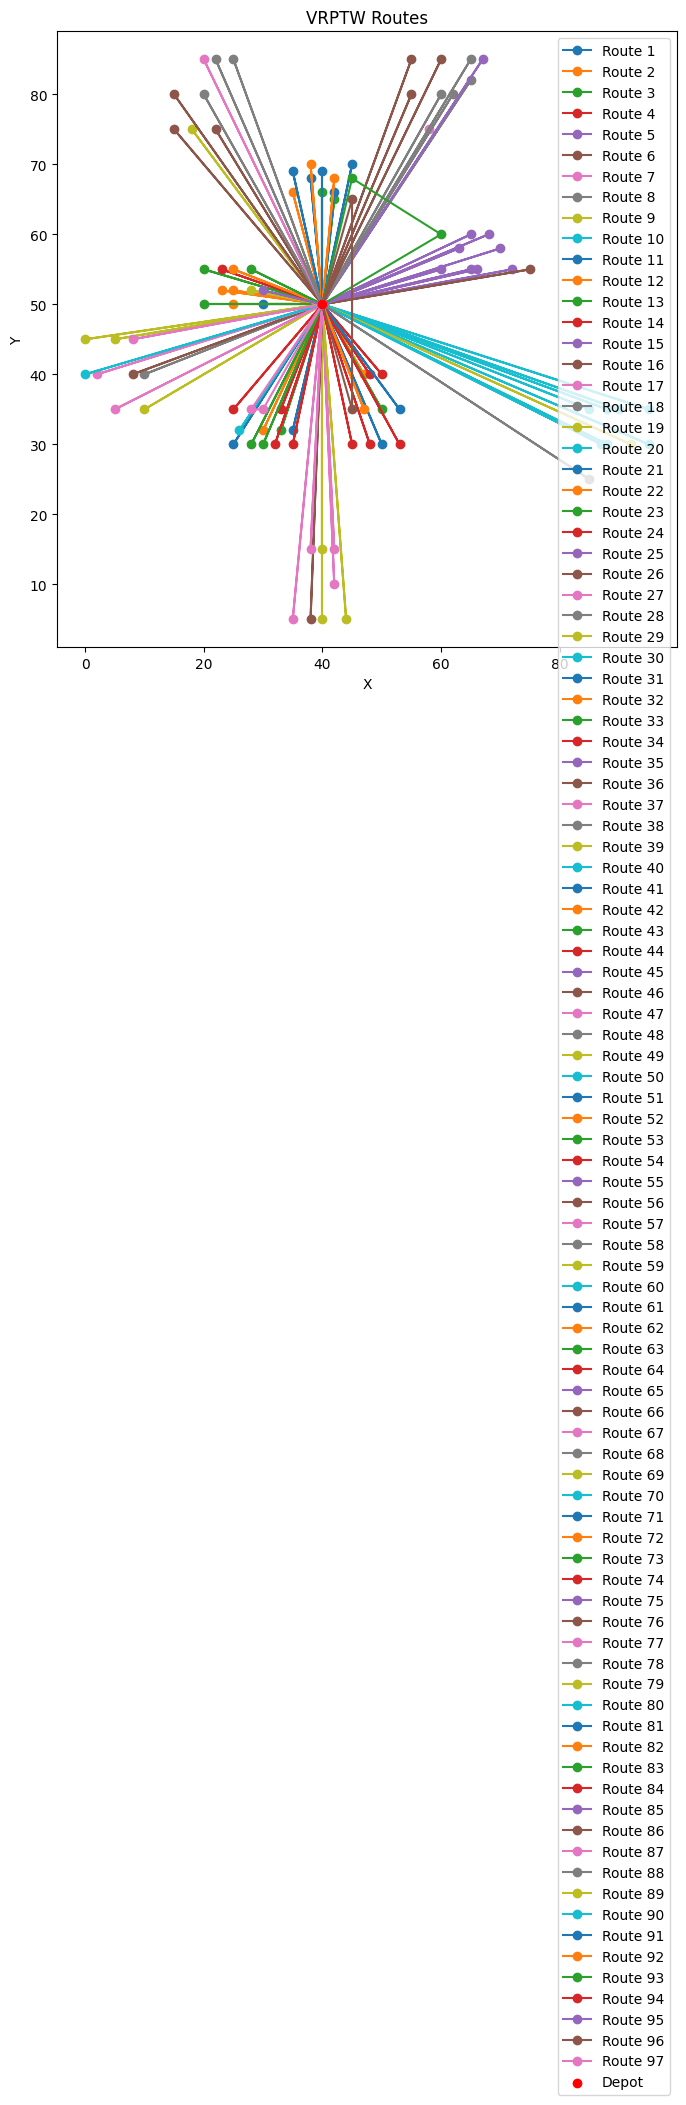

In [17]:
r = generate_initial_solution(CUSTOMERS)
print(len(r))
plotRoutes(r, DEPOT)